# From cell growth to growth curve

The purpose of this notebook is to take the data obtained with the notebook <em>Cell growth visualization</em>
, to isolate each microcolony that have not merged with each other from each position and to derive the growth curve.

## Packages

In [10]:
import numpy as np
import scipy
from scipy import ndimage as ndi
import pandas as pd
import skimage
from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import itertools
from scipy.optimize import curve_fit

## Microcolony isolation

For each position, each microcolony is isolated and stored as a separate image. Only those microcolonies that are not a grouping of several microcolonies are stored.

In [2]:
list_cells = [];
# directory of the numpy array .npy
file = "/path/to/file.npy" % (pos)
# load the array
img = np.load(file)
# apply otsu's algoritme for the segmentation
bw = np.uint8(img > 0)
# remove artifacts connected to image border
cleared = clear_border(bw,buffer_size=5)
# label image regions
label_image = label(cleared)
# split each microcolony
for region in regionprops(label_image):
    # cut a rectangle around segmented microcolony
    minr, minc, maxr, maxc = region.bbox
    imgg = img[minr:maxr,minc:maxc]
    # remove all the microcolonies that have merged with each other
    # number of frames
    num_fram = 36;
    if imgg.max() == num_fram:
        bw = np.uint8(imgg > num_fram-1)
        label_image = label(bw)
        # check if two or more microcolonies have merged with each other
        if len((regionprops(label_image))) == 1: 
            list_cells.append(img[minr:maxr,minc:maxc])

## Growth curves deriving

The growth curve of each microcolony is derived from the images stored in the preceding cell and saved in a data frame.

In [3]:
list_growth = [];
# number of frames
num_fram = 36;
# calculate the growth for each microcolony
for cell in list_cells:
    cell_growth = [];
    # calculate the number of pixels for each frame
    for i in range(num_fram):
        count = np.count_nonzero(cell >= num_fram-i)
        cell_growth.append(count)
    list_growth.append(cell_growth)
# prepare lists for the dictionnary
colony = [ [x]*len(list_growth[x]) for x in range(len(list_growth))]
colony = list(itertools.chain.from_iterable(colony))
size = [ list_growth[x] for x in range(len(list_growth))]
size = list(itertools.chain.from_iterable(size))
time = [list(range(80,800,20))]*len(list_growth)
time = list(itertools.chain.from_iterable(time))
# create a dictionnary
dict_growth = {"colony":colony,"time (min)":time,"size (pixel)":size}
# create a dataframe
df_growth = pd.DataFrame(data=dict_growth)

### Visualization

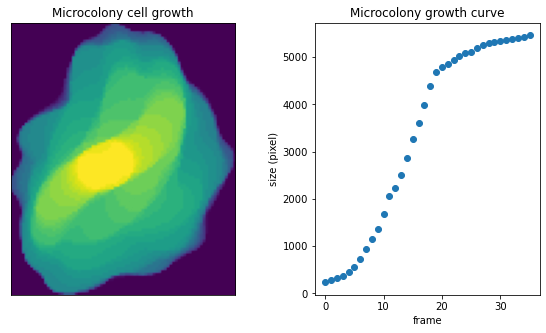

In [5]:
# microcolony to be displayed
colony = 5; 
# set the figure and two subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# microcolony cell growth
im = ax1.imshow(list_cells[colony])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Microcolony cell growth")
# microcolony growth curve
# number of frames
num_fram = 36;
y = range(num_fram)
ax2.scatter(y,list_growth[colony])
ax2.set_title("Microcolony growth curve")
ax2.set_xlabel("frame")
ax2.set_ylabel("size (pixel)")
# align the two subfigures
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
asp /= np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
ax2.set_aspect(asp)
#plt.savefig("output.pdf")

## Fitting the growth curve

<ipython-input-9-d805f1924f25>:3: RuntimeWarning: invalid value encountered in true_divide
  return N0*K/(N0+(K-N0)*np.exp(-r*t))


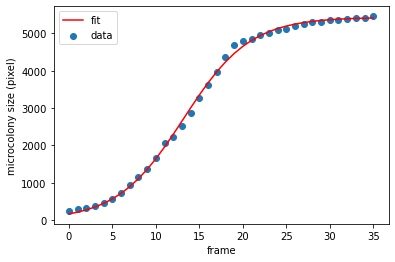

In [9]:
def func(t, N0, K, r):
    return N0*K/(N0+(K-N0)*np.exp(-r*t))
xdata = y
ydata = list_growth[colony]
plt.figure(figsize=(6, 4))
plt.scatter(xdata, ydata, label='data')
popt, pcov = curve_fit(func, xdata, ydata,p0=[50, 10000, 1/400],method="dogbox")
plt.plot(xdata, func(xdata, *popt), 'r-',label="fit")
plt.xlabel('frame')
plt.ylabel('microcolony size (pixel)')
plt.legend()
#plt.savefig("output.pdf")